# 2048 using DQN

In [1]:
# Import libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import collections

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")  # Using cuda

In [4]:
class DQN(nn.Module):
    ### Deep Q-Learning Network
    def __init__(self):
        super(DQN, self).__init__()
        
        self.conv_a = nn.Conv2d(16, 128, kernel_size=(1,2))        # Convolutional layers
        self.conv_b = nn.Conv2d(16, 128, kernel_size=(2,1))

        self.conv_aa = nn.Conv2d(128, 128, kernel_size=(1,2))
        self.conv_ab = nn.Conv2d(128, 128, kernel_size=(2,1))

        self.conv_ba = nn.Conv2d(128, 128, kernel_size=(1,2))
        self.conv_bb = nn.Conv2d(128, 128, kernel_size=(2,1))
        
        self.fc = nn.Sequential(         # Linear and Relu
            nn.Linear(7424, 256),
            nn.ReLU(),
            nn.Linear(256, 4)
        )
        
    def forward(self, x):
      # Forward function of the layer
        x_a = F.relu(self.conv_a(x))
        x_b = F.relu(self.conv_b(x))
        
        x_aa = F.relu(self.conv_aa(x_a))
        x_ab = F.relu(self.conv_ab(x_a))
        
        x_ba = F.relu(self.conv_ba(x_b))
        x_bb = F.relu(self.conv_bb(x_b))
        
        sh_a = x_a.shape
        sh_aa = x_aa.shape
        sh_ab = x_ab.shape
        sh_b = x_b.shape
        sh_ba = x_ba.shape
        sh_bb = x_bb.shape
        
        x_a = x_a.view(sh_a[0],sh_a[1]*sh_a[2]*sh_a[3])
        x_aa = x_aa.view(sh_aa[0],sh_aa[1]*sh_aa[2]*sh_aa[3])
        x_ab = x_ab.view(sh_ab[0],sh_ab[1]*sh_ab[2]*sh_ab[3])
        x_b = x_b.view(sh_b[0],sh_b[1]*sh_b[2]*sh_b[3])
        x_ba = x_ba.view(sh_ba[0],sh_ba[1]*sh_ba[2]*sh_ba[3])
        x_bb = x_bb.view(sh_bb[0],sh_bb[1]*sh_bb[2]*sh_bb[3])
        
        concat = torch.cat((x_a,x_b,x_aa,x_ab,x_ba,x_bb),dim=1)
        
        output = self.fc(concat)
        
        return output

In [5]:
class Memory(object):
  ## Class for replay buffer
    def __init__(self, memory_size, array):
        self.memory_size = memory_size
        self.buffer = collections.deque(array, maxlen=self.memory_size)

    def add(self, experience):
      # Add to buffer
        self.buffer.append(experience)

    def size(self):
        return len(self.buffer)

    def sample(self, batch_size):
      ## Sample min(batch_size, len(buffer)) elements for buffer
        if batch_size > len(self.buffer):
            batch_size = len(self.buffer)
        indexes = np.random.choice(np.arange(len(self.buffer)), size=batch_size, replace=False)
        return [self.buffer[i] for i in indexes]

    def clear(self):
        self.buffer.clear()

In [6]:
!pip install gym_2048
import gym_2048

     |████████████████████████████████| 1.5 MB 5.3 MB/s 
     |████████████████████████████████| 13.8 MB 16.9 MB/s 
  Created wheel for gym-2048: filename=gym_2048-0.2.6-py3-none-any.whl size=4697 sha256=5add35e3c2bb8abecd18d9b62fba2e90fedf20abe5902a1c8ba8a223c1aa0c25
  Stored in directory: /root/.cache/pip/wheels/68/98/9f/c396b6407bd4c0906c2a6ed5905202cd0d423dd2d6d8db05a2
  Created wheel for gym: filename=gym-0.10.11-py3-none-any.whl size=1588313 sha256=6671e04c741869cc94f5e44467da14497195ac2a67228c1d065eeb938a0db0d1
  Stored in directory: /root/.cache/pip/wheels/ec/c9/3a/068c5b80305e89c8de8b0a412e67ef2986cbad74895cfb9551
Successfully built gym-2048 gym
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.5
    Uninstalling numpy-1.21.5:
      Successfully uninstalled numpy-1.21.5
  Attempting uninstall: gym
    Found existing installation: gym 0.17.3
    Uninstalling gym-0.17.3:
      Successfully uninstalled gym-0.17.3
ERROR: pip's dependency resolver does not c

In [7]:
class Env(gym_2048.Base2048Env):
  ## Class inherits from base 2048 environment

    metadata = {
      'render.modes': ['human'], 'rewards':['score','nb_merge', 'nb_merge_max_tile', 'nb_empty_tiles']
  }

    def __init__(self, reward_mode = 'score'):
      super().__init__()
      self.reward_mode = reward_mode  # Several reward modes
    
    def step(self, action: int): 

        # Align board action with left action
        rotated_obs = np.rot90(self.board, k=action)
        reward, updated_obs = self._slide_left_and_merge(rotated_obs)
        self.board = np.rot90(updated_obs, k=4 - action)

        # Place one random tile on empty location
        self._place_random_tiles(self.board, count=1)

        done = self.is_done()

        return self.board, reward, done, {}

    def _slide_left_and_merge(self, board):
        ## Slides the board to the left
        result = []

        score = 0
        max_tile = 0 # Maximum value in the board
        for row in board:
          row = np.extract(row > 0, row)
          score_, max_row, result_row = self._try_merge(row)
          max_tile = max(max_tile, max_row)  
          score += score_
          row = np.pad(np.array(result_row), (0, 4 - len(result_row)),
                      'constant', constant_values=(0,))
          result.append(row)
        
        
        score = score + int(self.reward_mode == 'nb_merge_max_tile')*np.log2(max_tile)  # Different cases of rewards
        return score, np.array(result, dtype=np.int64)

    
    def _try_merge(self,row):
        # Merging tiles
        score = 0
        result_row = []

        i = 1
        max_row = 0
        while i < len(row):
          if row[i] == row[i - 1]:
            # If equal tiles, merge
            score += (row[i] + row[i - 1])*int(self.reward_mode == 'score') + int(self.reward_mode != 'score')
            max_row = max(max_row, row[i] + row[i - 1]) 
            result_row.append(row[i] + row[i - 1])
            i += 2
          else:
            max_row = max(max_row, row[i - 1])
            result_row.append(row[i - 1])
            i += 1
          

        if i == len(row):
          max_row = max(max_row, row[i - 1])
          result_row.append(row[i - 1])

        score = score*int(self.reward_mode != 'nb_empty_tiles') + (4-len(row))*int(self.reward_mode == 'nb_empty_tiles')  # (4 - len(row)) empty tiles in the row
      
        return score, max_row, result_row

In [8]:
def change_values(X):
    # Transform input of the DQN (normalization)
    power_mat = np.zeros(shape=(1,16,4,4),dtype=np.float32)
    for i in range(4):
        for j in range(4):
            if(X[i][j]==0):
                power_mat[0][0][i][j] = 1.0
            else:
                power = int(math.log(X[i][j],2))
                power_mat[0][power][i][j] = 1.0
    return power_mat

In [9]:
import time 

def training(n_epochs, reward_mode, online_dic, target_dic, epsilon, memory_buffer, opti, path = "/content/gdrive/My Drive/2048/", cont = True, print_rate = 100):             
    # Training the agent (we input parameters coming from previous training)
    
    GAMMA = 0.99 
    EXPLORE = 10000
    INITIAL_EPSILON = 0.1
    FINAL_EPSILON = 0.0001
    REPLAY_MEMORY = 50000   # Size of replay buffer
    BATCH = 16  # Length of batch extracted from buffer


    UPDATE_STEPS = 4
    
    begin_learn = False
    learn_steps = 0
    episode_reward = 0
    scores = []
    max_tiles = []
      
    env = Env(reward_mode = reward_mode)
    n_state = env.observation_space.shape[0]
    n_action = env.action_space.n

    if cont:
      ## In this case, we load previous training parameters to continue the training
        epsilon = np.float(np.load(path+epsilon))
        memory_replay = Memory(REPLAY_MEMORY, collections.deque(np.load(path+memory_buffer, allow_pickle = True)))

        onlineQNetwork = DQN().to(device)
        targetQNetwork = DQN().to(device)
        onlineQNetwork.load_state_dict(torch.load(path+online_dic))
        targetQNetwork.load_state_dict(torch.load(path+target_dic))
        
        optimizer = torch.load(path + opti)
        
    else:
      ## Start of the training

        epsilon = INITIAL_EPSILON
        memory_replay = Memory(REPLAY_MEMORY, np.array([]))
        onlineQNetwork = DQN().to(device)
        targetQNetwork = DQN().to(device)
        targetQNetwork.load_state_dict(onlineQNetwork.state_dict())

        optimizer = torch.optim.Adam(onlineQNetwork.parameters(), lr=1e-4)
      
      
    
    for epoch in range(n_epochs):
          
        state = env.reset()
        episode_reward = 0
        done = False
          
        while not done:
              
            x = change_values(state)
            x = torch.from_numpy(np.flip(x,axis=0).copy()).to(device)
              
            
            # Epsilon-greedy approach for the policy
            if random.random() < epsilon:
                action = random.randint(0,3)
                next_state, reward, done, _ = env.step(action)
                while (state == next_state).all():
                    action = random.randint(0,3)
                    next_state, reward, done, _ = env.step(action)             
            else:
                output = onlineQNetwork.forward(x) 
                for action in output.argsort()[0].cpu().numpy()[::-1]:
                    next_state, reward, done, _ = env.step(action)
                    if (state == next_state).all() == False:
                        break

              
            episode_reward += reward
            memory_replay.add((change_values(state), change_values(next_state), action, reward, done))  ## Adding data to the replay buffer
              
            if memory_replay.size() > 128:
                if begin_learn is False:
                    print('learn begin!')
                    begin_learn = True
                learn_steps += 1
                if learn_steps % UPDATE_STEPS == 0:
                    targetQNetwork.load_state_dict(onlineQNetwork.state_dict())
                batch = memory_replay.sample(BATCH)
                batch_state, batch_next_state, batch_action, batch_reward, batch_done = zip(*batch)

                batch_state = torch.FloatTensor(batch_state).squeeze(1).to(device)
                batch_next_state = torch.FloatTensor(batch_next_state).squeeze(1).to(device)
                batch_action = torch.Tensor(batch_action).unsqueeze(1).to(device)
                batch_reward = torch.Tensor(batch_reward).unsqueeze(1).to(device)
                batch_done = torch.FloatTensor(batch_done).unsqueeze(1).to(device)

                with torch.no_grad():
                    targetQ_next = targetQNetwork(batch_next_state)
                    y = batch_reward + (1 - batch_done) * GAMMA * torch.max(targetQ_next, dim=1, keepdim=True)[0]      # Q-learning update

                loss = F.mse_loss(onlineQNetwork(batch_state).gather(1, batch_action.long()), y)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                if epsilon > FINAL_EPSILON:
                    epsilon -= (INITIAL_EPSILON - FINAL_EPSILON) / EXPLORE
                      
            state = next_state
          
        scores.append(episode_reward)
        max_tiles.append(np.max(state))
              
        
        if epoch % print_rate == 0:
            env.render()
            #save_data(onlineQNetwork, targetQNetwork, optimizer, scores, max_tiles, epsilon, memory_replay, 0, 0, final = False)  #Uncomment to save data (not useful if you punctually train the agent)
            print("Game "+str(epoch)+", Episode reward: "+str(episode_reward))

    return(onlineQNetwork, targetQNetwork, optimizer, scores, max_tiles, epsilon, memory_replay)

In [10]:
def save_data(onlineQNetwork, targetQNetwork, optimizer, scores, max_tiles, epsilon, memory_replay, reward, run, path = "/content/drive/MyDrive/2048/", final = True):
  ## Saves data in drive (previously mounted)
  if final:
    suffix = '_reward'+str(reward)+'_run' + str(run)
  else: 
    suffix = ''

  torch.save(onlineQNetwork.state_dict(), path + "online"+suffix)
  torch.save(targetQNetwork.state_dict(), path+ 'target' + suffix)
  torch.save(optimizer,path+'opti'+ suffix)
  np.save(path+'scores' + suffix, scores)
  np.save(path+'max_tiles' + suffix, max_tiles)
  np.save(path+'eps' + suffix, epsilon)
  np.save(path+'mem' + suffix, np.array(memory_replay.buffer))
  return()

# Training

In [ ]:
# Reward 1 - Score (default)
onlineQNetwork, targetQNetwork, optimizer, scores, max_tiles, epsilon, memory_replay = training(1500, 'scores', 'online', 'target','eps.npy', 'mem.npy', 'opti', cont = False, print_rate = 100)
save_data(onlineQNetwork, targetQNetwork, optimizer, scores, max_tiles, epsilon, memory_replay, 1, 1)

/usr/local/lib/python3.7/dist-packages/gym_2048/env.py:120: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  board[tile_locs] = tiles


4 	2 	32 	2
2 	4 	8 	64
4 	8 	4 	2
2 	4 	2 	32
Game 0, Episode reward: 65.0
learn begin!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:93: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)


2 	8 	4 	2
4 	64 	8 	16
64 	32 	128 	4
2 	128 	16 	2
Game 100, Episode reward: 208.0
2 	4 	8 	2
8 	32 	16 	4
64 	128 	64 	8
2 	64 	128 	32
Game 200, Episode reward: 241.0
4 	2 	8 	16
2 	8 	2 	8
4 	2 	8 	16
2 	4 	16 	32
Game 300, Episode reward: 40.0
2 	4 	8 	2
4 	8 	16 	64
8 	64 	32 	8
16 	2 	128 	32
Game 400, Episode reward: 172.0
2 	16 	32 	4
16 	128 	2 	16
64 	32 	256 	32
2 	4 	128 	2
Game 500, Episode reward: 324.0
2 	4 	16 	8
4 	16 	32 	16
16 	4 	64 	128
128 	64 	512 	2
Game 600, Episode reward: 439.0
2 	4 	8 	4
8 	64 	16 	8
32 	128 	32 	16
128 	256 	64 	32
Game 700, Episode reward: 349.0
2 	4 	16 	2
4 	16 	32 	4
8 	64 	4 	8
32 	128 	64 	16
Game 800, Episode reward: 172.0
4 	8 	4 	2
2 	4 	16 	8
64 	32 	64 	32
16 	512 	128 	64
Game 900, Episode reward: 432.0
2 	16 	4 	2
4 	32 	16 	8
8 	16 	128 	16
16 	32 	256 	512
Game 1000, Episode reward: 480.0
4 	2 	4 	2
32 	8 	16 	4
4 	32 	64 	8
64 	256 	128 	32
Game 1100, Episode reward: 282.0
8 	16 	4 	2
16 	32 	64 	4
64 	16 	1024 	512
2 	128

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


()

In [ ]:
# Reward 2 - Merge and max tiles
onlineQNetwork, targetQNetwork, optimizer, scores, max_tiles, epsilon, memory_replay = training(1500, 'nb_merge_max_tile', 'online', 'target','eps.npy', 'mem.npy', 'opti', cont = False, print_rate = 100)
save_data(onlineQNetwork, targetQNetwork, optimizer, scores, max_tiles, epsilon, memory_replay, 3, 1)

/usr/local/lib/python3.7/dist-packages/gym_2048/env.py:120: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  board[tile_locs] = tiles


learn begin!
32 	2 	128 	16
8 	128 	32 	8
2 	16 	8 	4
16 	8 	4 	2
Game 0, Episode reward: 1248.0
64 	8 	4 	2
4 	32 	8 	4
2 	64 	16 	8
16 	2 	32 	16
Game 100, Episode reward: 726.0
64 	2 	64 	2
256 	64 	32 	4
64 	32 	8 	16
16 	8 	2 	4
Game 200, Episode reward: 2258.0
16 	4 	64 	2
4 	128 	2 	32
2 	16 	8 	2
4 	2 	16 	8
Game 300, Episode reward: 846.0
256 	128 	32 	4
128 	8 	4 	2
32 	16 	2 	4
16 	8 	4 	2
Game 400, Episode reward: 2233.0
64 	4 	16 	8
32 	16 	4 	2
16 	4 	2 	4
8 	2 	8 	2
Game 500, Episode reward: 494.0
16 	8 	2 	4
256 	16 	4 	2
64 	32 	16 	8
32 	8 	4 	16
Game 600, Episode reward: 1535.0
256 	2 	32 	16
128 	64 	16 	8
64 	32 	8 	4
16 	2 	4 	2
Game 700, Episode reward: 2313.0
512 	4 	2 	4
256 	16 	4 	2
64 	32 	2 	8
16 	2 	8 	2
Game 800, Episode reward: 3562.0
64 	128 	32 	8
512 	32 	16 	4
8 	16 	8 	2
16 	8 	2 	4
Game 900, Episode reward: 3229.0
256 	64 	32 	8
128 	2 	8 	4
64 	16 	4 	2
16 	8 	2 	4
Game 1000, Episode reward: 2209.0
512 	128 	2 	4
128 	64 	8 	16
64 	32 	16 	2
16 	8

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


16 	8 	32 	4
8 	32 	4 	16
4 	8 	64 	4
2 	4 	16 	2
Game 0, Episode reward: 90.0
learn begin!
2 	8 	4 	8
32 	128 	16 	4
128 	16 	64 	16
2 	4 	8 	4
Game 100, Episode reward: 190.0
4 	64 	4 	16
32 	8 	16 	8
2 	16 	8 	16
4 	2 	4 	8
Game 200, Episode reward: 81.0
4 	2 	4 	32
2 	8 	16 	64
8 	4 	64 	2
2 	16 	32 	64
Game 300, Episode reward: 130.0
16 	8 	16 	2
8 	16 	64 	256
32 	8 	4 	2
16 	4 	2 	4
Game 400, Episode reward: 189.0
4 	2 	4 	16
2 	4 	8 	32
4 	8 	32 	64
16 	32 	64 	128
Game 500, Episode reward: 174.0
2 	32 	2 	8
32 	256 	4 	2
4 	2 	64 	512
2 	4 	8 	32
Game 600, Episode reward: 427.0
4 	2 	4 	8
2 	64 	16 	64
16 	8 	32 	8
2 	4 	16 	4
Game 700, Episode reward: 97.0
2 	4 	8 	32
4 	8 	16 	256
2 	16 	64 	128
4 	2 	4 	16
Game 800, Episode reward: 239.0
2 	8 	2 	64
4 	64 	8 	256
16 	32 	256 	512
4 	16 	2 	4
Game 900, Episode reward: 554.0
2 	4 	2 	32
4 	2 	8 	128
2 	4 	32 	256
4 	8 	16 	64
Game 1000, Episode reward: 238.0
2 	16 	32 	4
8 	32 	128 	32
4 	16 	64 	128
2 	8 	16 	32
Game 1100, E

In [ ]:
# Reward 3 - Number of empty tiles
onlineQNetwork, targetQNetwork, optimizer, scores, max_tiles, epsilon, memory_replay = training(1500, 'nb_empty_tiles', 'online', 'target','eps.npy', 'mem.npy', 'opti', cont = False, print_rate = 10)
save_data(onlineQNetwork, targetQNetwork, optimizer, scores, max_tiles, epsilon, memory_replay, 2, 1)  

/usr/local/lib/python3.7/dist-packages/gym_2048/env.py:120: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  board[tile_locs] = tiles


2 	8 	4 	2
8 	32 	8 	4
32 	4 	32 	8
2 	8 	4 	16
Game 0, Episode reward: 302.0
learn begin!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:93: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)


2 	8 	4 	2
4 	64 	8 	4
32 	2 	16 	8
2 	4 	2 	32
Game 10, Episode reward: 424.0
4 	2 	8 	4
2 	16 	32 	8
16 	128 	16 	4
8 	32 	4 	2
Game 20, Episode reward: 463.0
2 	4 	8 	16
8 	2 	4 	2
2 	4 	16 	8
4 	2 	4 	2
Game 30, Episode reward: 227.0
2 	4 	2 	8
4 	32 	4 	2
2 	4 	32 	4
16 	2 	4 	32
Game 40, Episode reward: 312.0
4 	8 	4 	2
2 	4 	32 	4
128 	16 	128 	8
4 	64 	2 	32
Game 50, Episode reward: 637.0
4 	16 	4 	2
2 	32 	8 	4
4 	128 	32 	8
2 	8 	4 	16
Game 60, Episode reward: 548.0
2 	4 	2 	8
16 	32 	256 	16
2 	4 	8 	4
4 	2 	4 	16
Game 70, Episode reward: 826.0
2 	16 	4 	2
4 	32 	16 	8
8 	4 	8 	64
16 	2 	16 	2
Game 80, Episode reward: 543.0
16 	4 	2 	4
4 	8 	4 	2
8 	16 	32 	16
16 	32 	256 	32
Game 90, Episode reward: 1064.0
4 	16 	4 	2
8 	32 	8 	4
128 	256 	2 	32
64 	4 	32 	2
Game 100, Episode reward: 1186.0
4 	2 	8 	2
2 	16 	4 	8
8 	64 	8 	32
64 	128 	256 	4
Game 110, Episode reward: 1399.0
2 	4 	8 	2
4 	2 	4 	32
2 	4 	8 	4
64 	256 	32 	8
Game 120, Episode reward: 1050.0
2 	4 	8 	2
4 	8 	32

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


()

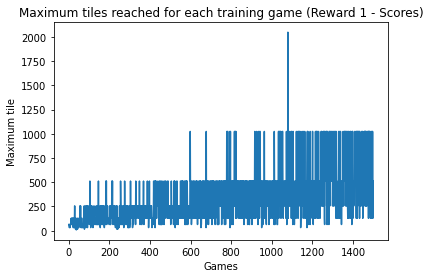

In [3]:
#Reward -1 Score
path = "/content/drive/MyDrive/2048/"
suffix = "_reward1_run1.npy"
scores_1 = np.load(path+ "scores" + suffix)
max_tiles_1 = np.load(path+ "max_tiles" + suffix)
plt.plot(max_tiles_1)
plt.xlabel('Games')
plt.ylabel('Maximum tile')
plt.title('Maximum tiles reached for each training game (Reward 1 - Scores)')
plt.show()

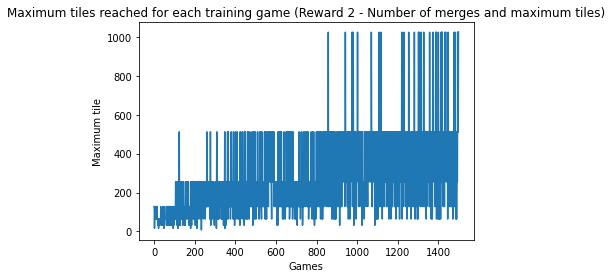

In [4]:
# Reward - 2 max tiles
path = "/content/drive/MyDrive/2048/"
suffix = "_reward3_run1.npy"
scores_2 = np.load(path+ "scores" + suffix)
max_tiles_2 = np.load(path+ "max_tiles" + suffix)
plt.plot(max_tiles_2)
plt.xlabel('Games')
plt.ylabel('Maximum tile')
plt.title('Maximum tiles reached for each training game (Reward 2 - Number of merges and maximum tiles)')
plt.show()

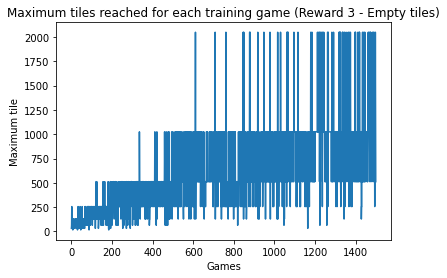

In [10]:
# Reward -3 Empty tiles
path = "/content/drive/MyDrive/2048/"
suffix = "_reward2_run1.npy"
#suffix2 = "_reward1_run2.npy"
scores_3 = np.load(path+ "scores" + suffix)
max_tiles_3 = np.load(path+ "max_tiles" + suffix)
plt.plot(max_tiles_3)
plt.xlabel('Games')
plt.ylabel('Maximum tile')
plt.title('Maximum tiles reached for each training game (Reward 3 - Empty tiles)')
plt.show()

Text(0.5, 1.0, 'Reward training curve for reward 3 (moving average)')

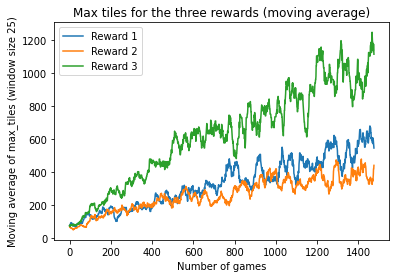

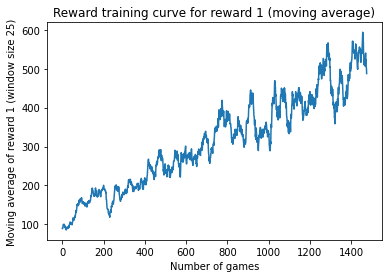

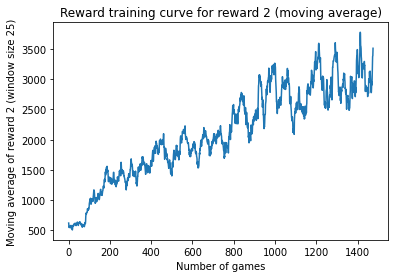

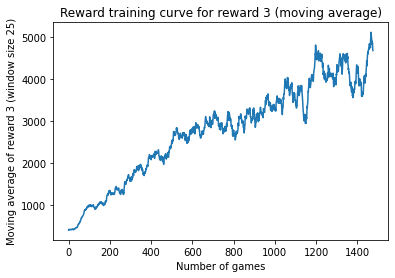

In [11]:
# function to find moving averages
def moving_average(a, wind=25) :
    # Returns the moving average array associated to a with a window wind
    ret = np.cumsum(a, dtype=float)
    ret[wind:] = ret[wind:] - ret[:-wind]
    return ret[wind - 1:] / wind


plt.figure(0)
plt.xlabel('Number of games')
plt.ylabel('Moving average of max_tiles (window size 25)')
plt.plot(moving_average(max_tiles_1), label = 'Reward 1')
plt.plot(moving_average(max_tiles_2), label = 'Reward 2')
plt.plot(moving_average(max_tiles_3), label = 'Reward 3')
plt.legend(loc = 'best')

plt.title('Max tiles for the three rewards (moving average)')


plt.figure(1)
plt.xlabel('Number of games')
plt.ylabel('Moving average of reward 1 (window size 25)')
plt.plot(moving_average(scores_1))
plt.title('Reward training curve for reward 1 (moving average)')

plt.figure(2)
plt.xlabel('Number of games')
plt.ylabel('Moving average of reward 2 (window size 25)')
plt.plot(moving_average(scores_2))
plt.title('Reward training curve for reward 2 (moving average)')

plt.figure(3)
plt.xlabel('Number of games')
plt.ylabel('Moving average of reward 3 (window size 25)')
plt.plot(moving_average(scores_3))
plt.title('Reward training curve for reward 3 (moving average)')

# Testing results

In [11]:
def play_game(env, QNetwork, render = True):
    ## Plays one unique game given an environment and a trained DQN
    state = env.reset()
    episode_reward = 0
    done = False
        
    while not done:
            
        x = change_values(state)
        x = torch.from_numpy(np.flip(x,axis=0).copy()).to(device)
        output = QNetwork.forward(x) 
        for action in output.argsort()[0].cpu().numpy()[::-1]:
             next_state, reward, done, _ = env.step(action)
             if (state == next_state).all() == False:
                     break

            
        episode_reward += reward
        state = next_state
            
    if render:    
      env.render()         
      print( "Score: "+str(episode_reward))

    return(state)

def results(reward_mode):
    # Displays results (proportions of games reaching each existing level of max_tile) given a reward_mode
    if reward_mode == 'nb_merge_max_tile':
      reward_num = 3
      run = 1
    elif reward_mode == 'score':
      reward_num = 1
      run = 1
    elif reward_mode == 'nb_empty_tiles':
      reward_num = 2
      run = 1

    test_env = Env(reward_mode = reward_mode)

    path = "/content/drive/MyDrive/2048/"
    QNetwork = DQN().to(device)
    filename = 'online_reward' + str(reward_num)+ '_run' + str(run)
    QNetwork.load_state_dict(torch.load(path + filename))
    
    dic_max = {}
    for i in range(13):
      dic_max[2**i]=0

    n_games = 1000

    for k in range(n_games):
      if (k%50 == 0):
        print(str(k) + " games played ")
      grid = play_game(test_env, QNetwork, render = False)
      max_tile = np.max(grid)
      dic_max[max_tile]=dic_max[max_tile]+1

    for key in dic_max:
      dic_max[key] = dic_max[key]/n_games

    return(dic_max)

In [17]:
results('score')

/usr/local/lib/python3.7/dist-packages/gym_2048/env.py:120: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  board[tile_locs] = tiles


0 games played 
50 games played 
100 games played 
150 games played 
200 games played 
250 games played 
300 games played 
350 games played 
400 games played 
450 games played 
500 games played 
550 games played 
600 games played 
650 games played 
700 games played 
750 games played 
800 games played 
850 games played 
900 games played 
950 games played 


{1: 0.0,
 2: 0.0,
 4: 0.0,
 8: 0.0,
 16: 0.0,
 32: 0.002,
 64: 0.011,
 128: 0.046,
 256: 0.166,
 512: 0.448,
 1024: 0.315,
 2048: 0.012,
 4096: 0.0}

In [14]:
results('nb_merge_max_tile')

/usr/local/lib/python3.7/dist-packages/gym_2048/env.py:120: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  board[tile_locs] = tiles


0 games played 
50 games played 
100 games played 
150 games played 
200 games played 
250 games played 
300 games played 
350 games played 
400 games played 
450 games played 
500 games played 
550 games played 
600 games played 
650 games played 
700 games played 
750 games played 
800 games played 
850 games played 
900 games played 
950 games played 


{1: 0.0,
 2: 0.0,
 4: 0.0,
 8: 0.0,
 16: 0.0,
 32: 0.004,
 64: 0.034,
 128: 0.177,
 256: 0.31,
 512: 0.39,
 1024: 0.085,
 2048: 0.0,
 4096: 0.0}

In [12]:
results('nb_empty_tiles')

/usr/local/lib/python3.7/dist-packages/gym_2048/env.py:120: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  board[tile_locs] = tiles


0 games played 
50 games played 
100 games played 
150 games played 
200 games played 
250 games played 
300 games played 
350 games played 
400 games played 
450 games played 
500 games played 
550 games played 
600 games played 
650 games played 
700 games played 
750 games played 
800 games played 
850 games played 
900 games played 
950 games played 


{1: 0.0,
 2: 0.0,
 4: 0.0,
 8: 0.0,
 16: 0.0,
 32: 0.001,
 64: 0.001,
 128: 0.005,
 256: 0.029,
 512: 0.147,
 1024: 0.492,
 2048: 0.325,
 4096: 0.0}